In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import os
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
stack_fixed = 'MD595'
stack_moving = 'atlasV2'

In [14]:
classifier_setting = 2
warp_setting = 1

In [15]:
if warp_setting == 1:
    upstream_warp_setting = None
    transform_type = 'affine'
elif warp_setting == 2:
    upstream_warp_setting = 1
    transform_type = 'rigid'
else:
    raise Exception('Warp setting not recognized.')

In [7]:
# all_known_structures_sided_surround = [convert_to_surround_name(s, margin='x1.5') for s in all_known_structures_sided]
# all_known_structures_sided_with_surround = sorted(all_known_structures_sided + all_known_structures_sided_surround)

In [16]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_score_volume_all_known_structures(stack=stack_moving, sided=True)

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/score_volumes/atlasV2_down32_scoreVolume_outerContour.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/atlasV2/score_volumes/atlasV2_down32_scoreVolume_sp5.bp
Score volume for sp5 does not exist.


In [17]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_score_volume_all_known_structures(stack=stack_fixed, classifier_setting=classifier_setting)

File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD595/score_volumes/MD595_down32_scoreVolume_outerContour_setting_2.bp
Score volume for outerContour does not exist.
File does not exist: /oasis/projects/nsf/csd395/yuncong/CSHL_volumes/MD595/score_volumes/MD595_down32_scoreVolume_sp5_setting_2.bp
Score volume for sp5 does not exist.


In [18]:
label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                    if name_m in ['7N_L', '7N_R', '12N', '5N_L', '5N_R']}

# label_mapping_m2f = {label_m: structure_to_label_fixed[convert_to_original_name(name_m)] 
#                      for label_m, name_m in label_to_structure_moving.iteritems()}

In [19]:
# volume_moving_structure_sizes = {l: np.count_nonzero(vol > 0) for l, vol in volume_moving.iteritems()}

In [20]:
label_weights_m = {}
for label_m, name_m in label_to_structure_moving.iteritems():
    if 'surround' in name_m:
        label_weights_m[label_m] = 0
    else:
        label_weights_m[label_m] = 1
#         label_weights_m[label_m] = np.minimum(1e5 / volume_moving_structure_sizes[label_m], 1.)

# Compute Registration

In [21]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [22]:
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[structure_to_label_moving['7N_L']])

In [23]:
gradient_filepath_map_f = {ind_f: DataManager.get_score_volume_gradient_filepath_template(\
                            stack=stack_fixed, structure=label_to_structure_fixed[ind_f],
                            downscale=32, setting=classifier_setting)
                           for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [24]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

set([2, 5, 7])


load gradient 2: 3.675937 seconds
load gradient 5: 4.376242 seconds
load gradient 7: 4.894658 seconds
overall: 12.947308 seconds


In [25]:
aligner.set_label_weights(label_weights=label_weights_m)

In [26]:
# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

while True:

    try:
        T, scores = aligner.optimize(type=transform_type, max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
                                     indices_m=None,
                                    grid_search_iteration_number=30,
                                     grid_search_sample_number=100,
                                     grad_computation_sample_number=1e5,
                                     lr1=10, lr2=0.1,
                                    std_tx=50, std_ty=50, std_tz=100, std_theta_xy=np.deg2rad(10))
        
        break
        
    except Exception as e:
        sys.stderr.write(e.message + '\n')


grid search: 0.715761 seconds
-inf 0.096292
grid search: 0.371879 seconds
0.096292 0.097844
grid search: 0.375715 seconds
0.097844 0.106835
grid search: 0.372216 seconds
0.106835 0.107299
grid search: 0.271112 seconds
grid search: 0.273998 seconds
grid search: 0.269451 seconds
0.107299 0.107324
grid search: 0.269384 seconds
grid search: 0.269603 seconds
0.107324 0.108367
grid search: 0.277849 seconds
0.108367 0.109063
grid search: 0.273829 seconds
grid search: 0.273422 seconds
grid search: 0.275033 seconds
grid search: 0.271772 seconds
0.109063 0.109171
grid search: 0.271992 seconds
grid search: 0.271955 seconds
grid search: 0.271773 seconds
grid search: 0.272007 seconds
grid search: 0.277868 seconds
grid search: 0.273493 seconds
grid search: 0.273959 seconds
grid search: 0.273621 seconds
grid search: 0.275067 seconds
grid search: 0.271881 seconds
grid search: 0.278107 seconds
grid search: 0.272421 seconds
grid search: 0.275856 seconds
grid search: 0.275540 seconds
grid search: 0.27719

params_best_upToNow [-19.60154214  -7.12816042   6.30237967  -0.22034546]


step: 0.13 seconds
score: 0.087120
iteration 2
step: 0.13 seconds
score: 0.092995
iteration 3
step: 0.13 seconds
score: 0.090654
iteration 4
step: 0.13 seconds
score: 0.121909
iteration 5
step: 0.13 seconds
score: 0.140380
iteration 6
step: 0.13 seconds
score: 0.140057
iteration 7
step: 0.13 seconds
score: 0.142749
iteration 8
step: 0.13 seconds
score: 0.134163
iteration 9
step: 0.13 seconds
score: 0.114675
iteration 10
step: 0.13 seconds
score: 0.142024
iteration 11
step: 0.13 seconds
score: 0.141620
iteration 12
step: 0.13 seconds
score: 0.140370
iteration 13
step: 0.13 seconds
score: 0.127788
iteration 14
step: 0.13 seconds
score: 0.145207
iteration 15
step: 0.13 seconds
score: 0.145661
iteration 16
step: 0.13 seconds
score: 0.146481
iteration 17
step: 0.13 seconds
score: 0.144368
iteration 18
step: 0.13 seconds
score: 0.146941
iteration 19
step: 0.13 seconds
score: 0.145657
iteration 20
step: 0.13 seconds
score: 0.147714
iteration 21
step: 0.13 seconds
score: 0.147257
iteration 22


[[  0.95395654   0.29727645  -0.03992034 -30.41558902]
 [ -0.28188781   0.93403275   0.21936749   6.06975864]
 [  0.10249969  -0.19801399   0.97482525  15.36102851]]
0.151859971695 0.151859009638


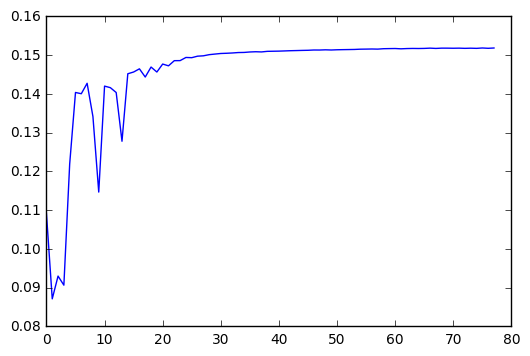

In [27]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

# Export parameters and score plots

In [28]:
params_fp = \
DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                              classifier_setting_m=classifier_setting,
                                              classifier_setting_f=classifier_setting,
                                              warp_setting=warp_setting,
                                              trial_idx=0)

In [54]:
params_fp = \
DataManager.get_alignment_parameters_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                              classifier_setting_m=classifier_setting,
                                              classifier_setting_f=classifier_setting,
                                              warp_setting=warp_setting,
                                              trial_idx=0)

DataManager.save_alignment_parameters(params_fp, T, 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

score_plot_fp = \
DataManager.get_alignment_score_plot_filepath(stack_m=stack_moving, stack_f=stack_fixed,
                                                     classifier_setting_m=classifier_setting,
                                                     classifier_setting_f=classifier_setting,
                                                     warp_setting=warp_setting,
                                                     trial_idx=0)
fig = plt.figure();
plt.plot(scores);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)